In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline
from scipy import optimize, fftpack

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [5]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

max_speeds_sort = np.sort(max_speeds)
cprob = np.arange(1, years_nb+1, 1) / (years_nb + 1)
quantile_func = UnivariateSpline(cprob, max_speeds_sort, s=0)

fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
print (fifty_wind)

36.96971413811491


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [6]:
def model(t, a, b, c, d):
    return a * np.sin(b * t + c) + d

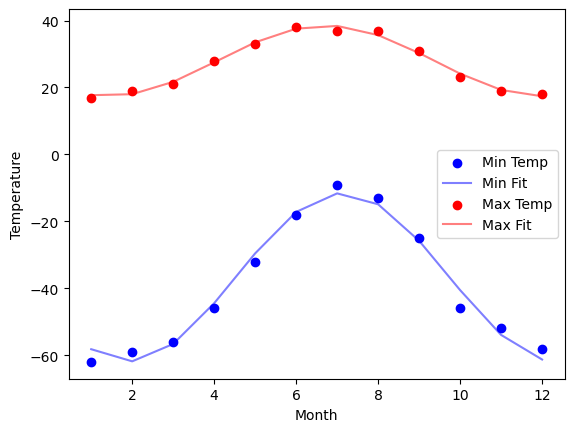

Phase Shift for Max Temp: 0.73 +- 0.16
Phase Shift for Min Temp: 0.42 +- 0.15


In [7]:
max_temp = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
t = np.arange(1, 13)

param_min, cov_min = optimize.curve_fit(model, t, min_temp, p0=[30, 2*np.pi/12, 0, -30])
param_max, cov_max = optimize.curve_fit(model, t, max_temp, p0=[30, 2*np.pi/12, 0, -30])

phi_max = param_max[2]
phi_min = param_min[2]
sigma_min = np.sqrt(np.diag(cov_min))
sigma_max = np.sqrt(np.diag(cov_max))

plt.scatter(t, min_temp, color='blue', label='Min Temp')
plt.plot(t, model(t, param_min[0], param_min[1],param_min[2], param_min[3]), color='blue', alpha=0.5, label=f'Min Fit')
plt.scatter(t, max_temp, color='red', label='Max Temp')
plt.plot(t, model(t, param_max[0], param_max[1], param_max[2], param_max[3]), color='red', alpha=0.5, label=f'Max Fit')

plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.show()

# Compare phase shifts
print(f"Phase Shift for Max Temp: {phi_max:.2f} +- {sigma_min[2]:.2f}")
print(f"Phase Shift for Min Temp: {phi_min:.2f} +- {sigma_max[2]:.2f}")

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [8]:
def func(XY):
    x, y = XY
    return (4 - 2.1*x**2 + x**4/3)*x**2 + x*y + (4*y**2 - 4)*y**2

There are: 4 minima
(x,y)= [-1.70360667  0.79608358]
f(x_min) = -0.2154638243836946
(x,y)= [ 0.08984201 -0.71265644]
f(x_min) = -1.0316284534898674
(x,y)= [ 1.70360671 -0.79608357]
f(x_min) = -0.21546382438371914
(x,y)= [-0.08984201  0.71265634]
f(x_min) = -1.0316284534898421


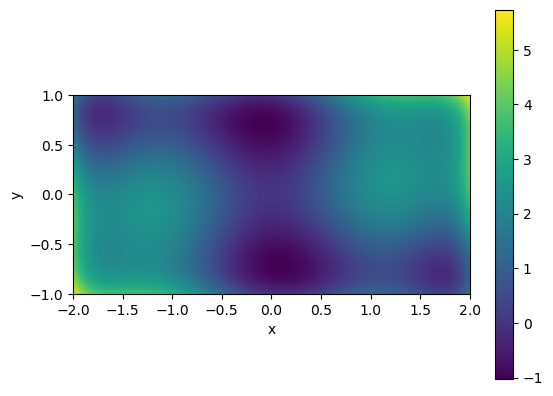

In [9]:
x = np.linspace(-2, 2, 1000)
y = np.linspace(-1, 1, 1000)

X, Y = np.meshgrid(x, y)
Z = func([X, Y])
Guess = [[2,10], [-32,1], [-43,-11], [0,0]]
solutions = []

for i in Guess:
    minimum = optimize.minimize(func, i, method='Powell')
    solutions.append(minimum.x)

print("There are:", len(solutions), "minima")
for j in solutions:
    print ("(x,y)=", j)
    print ("f(x_min) =", func(j))
    
plt.imshow(Z, extent=(-2, 2, -1, 1), origin='lower', cmap='viridis')
plt.colorbar()  
plt.xlabel("x")
plt.ylabel("y")
plt.show()

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

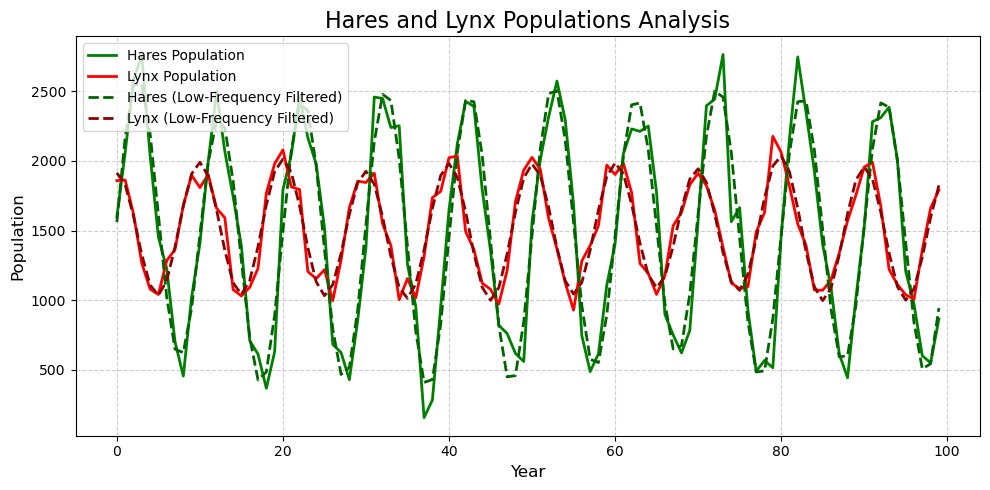

In [13]:
from scipy import fftpack

n = 100
np.random.seed(42)  
years = np.arange(0, n)  
hares = 1500 + 1000 * np.sin(2 * np.pi * years / 10) + np.random.normal(0, 200, n)  
lynxs = 1500 + 500 * np.cos(2 * np.pi * years / 10) + np.random.normal(0, 100, n)  

fft_hares = fftpack.fft(hares)
fft_lynxs = fftpack.fft(lynxs)
fft_hares_power = abs(fft_hares)
fft_lynxs_power = abs(fft_lynxs)
sample_freq = fftpack.fftfreq(years.size, d=1)

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_hares_freq = freqs[fft_hares_power[pos_mask].argmax()]
peak_lynxs_freq = freqs[fft_lynxs_power[pos_mask].argmax()]

high_freq_hares = fft_hares.copy()
high_freq_lynxs = fft_lynxs.copy()
high_freq_hares[np.abs(sample_freq) > peak_hares_freq] = 0
high_freq_lynxs[np.abs(sample_freq) > peak_lynxs_freq] = 0

filtered_sig_hares = fftpack.ifft(high_freq_hares)
filtered_sig_lynxs = fftpack.ifft(high_freq_lynxs)

plt.figure(figsize=(10, 5))
plt.plot(years, hares, label='Hares Population', color='green', linestyle='-', linewidth=2)
plt.plot(years, lynxs, label='Lynx Population', color='red', linestyle='-', linewidth=2)
plt.plot(years, filtered_sig_hares, label='Hares (Low-Frequency Filtered)', color='darkgreen', linestyle='--', linewidth=2)
plt.plot(years, filtered_sig_lynxs, label='Lynx (Low-Frequency Filtered)', color='darkred', linestyle='--', linewidth=2)

plt.title('Hares and Lynx Populations Analysis', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Population', fontsize=12)

plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

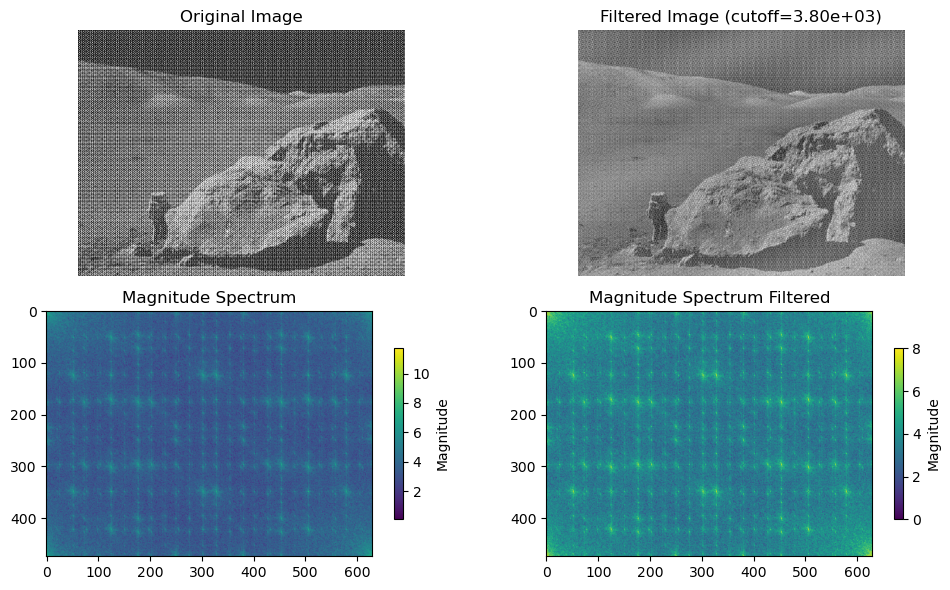

In [4]:
img = plt.imread("moonlanding.png")

fft_img = fftpack.fft2(img)
spectrum_magnitude = np.abs(fft_img)

threshold = 0.03 * np.max(spectrum_magnitude)
mask = (spectrum_magnitude > threshold)
fft_img[mask] = 0 
filtered_spectrum = np.abs(fft_img)

img_filtered = fftpack.ifft2(fft_img).real   


fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(img_filtered, cmap='gray')
axs[0, 1].set_title(f"Filtered Image (cutoff={threshold:.2e})")
axs[0, 1].axis('off')

im1 = axs[1, 0].imshow(np.log(1 + spectrum_magnitude), cmap='viridis')
axs[1, 0].set_title("Magnitude Spectrum")
cbar = fig.colorbar(im1, ax=axs[1, 0], shrink=0.7)
cbar.set_label("Magnitude")

im2 = axs[1, 1].imshow(np.log(1 + filtered_spectrum), cmap='viridis')
axs[1, 1].set_title("Magnitude Spectrum Filtered")
cbar = fig.colorbar(im2, ax=axs[1, 1], shrink=0.7)
cbar.set_label("Magnitude")

plt.tight_layout()
plt.show()